<a href="https://colab.research.google.com/github/Amaranta7/Practica1_COVID_mineria/blob/main/P1_COVID_mineria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importacion de Datos 

In [ ]:
import requests
import io
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate
from typing import Tuple, List


def get_soup(url: str) -> BeautifulSoup:
    response = requests.get(url)
    return BeautifulSoup(response.content, 'html.parser')

def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt='orgtbl'))

def get_csv_from_url(url: str) -> pd.DataFrame:
    s = requests.get(url).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

def Covid() -> pd.DataFrame:
    soup = get_soup("https://es.wikipedia.org/wiki/Pandemia_de_COVID-19_en_México")
    list_of_lists = []
    rows = soup.find_all("table")[7].find_all('tr')
    for row in rows[1:]:
        columns = row.find_all('td')
        listado_de_valores_en_columnas = [column.text.strip() for column in columns]
        list_of_lists.append(listado_de_valores_en_columnas)
    return pd.DataFrame(list_of_lists, columns=["Estados","Casos","Cantidad de Fallecidos","porcentaje de Fallecidos","Cantidad de Recuperados","porcentaje de Recuperados","Casos por 100,000 habitantes","Reporte"])

df = Covid()

df.head()

,Estados,Casos,Cantidad de Fallecidos,porcentaje de Fallecidos,Cantidad de Recuperados,porcentaje de Recuperados,"Casos por 100,000 habitantes",Reporte
0,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None
2,Ciudad de México,592 456,38 132,6.44,531 532,89.72,6643.4,[126]​
3,Jalisco,229 072,11 120,4.85,210 879,92.06,2739.1,[127]​
4,Estado de México,228 018,30 527,13.39,185 357,81.29,1261.9,[128]​


In [ ]:
df.to_csv("Estimadores_Covid.csv", index=False)

Análisis de Datos

Import librerias que usaremos para graficas, analysis y tablas 

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
df_Modif = pd.read_csv("Estimadores_Covid.csv")
#Eliminamos las columnas mencionadas despues de .drop que sera el data fram de df_Modif
df_Modif = df_Modif.drop(['porcentaje de Fallecidos', 'porcentaje de Recuperados','Casos por 100,000 habitantes','Reporte'], axis=1)

In [ ]:
df_Modif.head(5)

,Estados,Casos,Cantidad de Fallecidos,Cantidad de Recuperados
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Ciudad de México,592 456,38 132,531 532
3,Jalisco,229 072,11 120,210 879
4,Estado de México,228 018,30 527,185 357


In [ ]:
#Aqui agrupamos las columnas de cantidad de fallecidoa y la de cantidad de recuperados y la ponemos con la columna de casos
df_by_casos = df_Modif.groupby(["Cantidad de Fallecidos", "Cantidad de Recuperados"])[["Casos"]].aggregate(pd.DataFrame.sum)
df_by_casos.head(5)

,,Casos
Cantidad de Fallecidos,Cantidad de Recuperados,
1081,7415,8789
10 092,158 519,170 304
10 261,111 612,126 043
10 392,59 711,76 649
11 120,210 879,229 072


Aqui le asinamos ceros a los valores que tienen "null", es decir que son nulos 

In [ ]:

#Aqui le asinamos ceros a los valores que tienen "null", con .fillna(0), es decir que son nulos 
df_Help = df_Modif[["Cantidad de Recuperados","Cantidad de Fallecidos","Casos"]].fillna(0)
df_Help.columns = ['Cantidad_de_Recuperados','Cantidad_de_Fallecidos','Casos']
df_Help.head(5)

,Cantidad_de_Recuperados,Cantidad_de_Fallecidos,Casos
0,0,0,0
1,0,0,0
2,531 532,38 132,592 456
3,210 879,11 120,229 072
4,185 357,30 527,228 018


Aqui observamos la informacion y tipos de datos que tiene el df_Help, observando que tiene datos que son tipo object, es decir que tienen texto , entonces tendremos que limiparlos para que sean de tipo texto 

In [ ]:
df_Help.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cantidad_de_Recuperados  36 non-null     object
 1   Cantidad_de_Fallecidos   36 non-null     object
 2   Casos                    36 non-null     object
dtypes: object(3)
memory usage: 992.0+ bytes


Aqui elimine las dos últimas filas y las dos últimas columnas del Data Frame pues son 0. Pero no modifico el DF original, lo asigno a uno nuevo.

In [ ]:
df_Help_2 = df_Help.drop([0,1,34,35], axis = 0).reset_index().drop(['index'],axis = 1)

In [ ]:
df_Help_2

,Cantidad_de_Recuperados,Cantidad_de_Fallecidos,Casos
0,531 532,38 132,592 456
1,210 879,11 120,229 072
2,185 357,30 527,228 018
3,158 519,10 092,170 304
4,111 612,10 261,126 043
5,59 711,10 392,76 649
6,61 824,6223,69 288
7,59 024,5837,65 991
8,52 721,3985,62 082
9,55 173,3879,59 752


Aqui modifique me fije que las columnas de casos, cantidad_de_fallecidos,cantidad_de_recuperados son de tipo object por que tienen "\xa" entre los numeros y eso hay que eliminarlo. para que quede solo dato numerico.

In [ ]:
#Aqui modifique la primer columna de"Cantidad_de_Recuperados" para que quedaran puros datos numericos enteros.
df_Help_2["Cantidad_de_Recuperados"] = df_Help_2["Cantidad_de_Recuperados"].apply(lambda x: x.replace(u'\xa0', u''))
df_Help_2["Cantidad_de_Recuperados"]= df_Help_2["Cantidad_de_Recuperados"].astype(int)
df_Help_2["Cantidad_de_Recuperados"]

0     531532
1     210879
2     185357
3     158519
4     111612
5      59711
6      61824
7      59024
8      52721
9      55173
10     49559
11     48606
12     50586
13     46438
14     45402
15     36400
16     39185
17     30246
18     26758
19     29356
20     29772
21     26777
22     23514
23     24711
24     25102
25     20702
26     17273
27     11680
28      8896
29      8243
30      8512
31      7415
Name: Cantidad_de_Recuperados, dtype: int64

In [ ]:
#Aqui modifique la segunda columna de"Cantidad_de_Fallecidos" para que quedaran puros datos numericos enteros.
df_Help_2["Cantidad_de_Fallecidos"] = df_Help_2["Cantidad_de_Fallecidos"].apply(lambda x: x.replace(u'\xa0', u''))
df_Help_2["Cantidad_de_Fallecidos"]= df_Help_2["Cantidad_de_Fallecidos"].astype(int)
df_Help_2["Cantidad_de_Fallecidos"]

0     38132
1     11120
2     30527
3     10092
4     10261
5     10392
6      6223
7      5837
8      3985
9      3879
10     5036
11     5536
12     5000
13     8584
14     4589
15     7687
16     3101
17     3895
18     5725
19     5555
20     3667
21     2618
22     2633
23     2782
24     1343
25     2327
26     2455
27     2242
28     1769
29     1206
30     1468
31     1081
Name: Cantidad_de_Fallecidos, dtype: int64

In [ ]:
#Aqui modifique la Tercer columna de"Casos" para que quedaran puros datos numericos enteros.
df_Help_2["Casos"] = df_Help_2["Casos"].apply(lambda x: x.replace(u'\xa0', u''))
df_Help_2["Casos"] = df_Help_2["Casos"].astype(int)
df_Help_2["Casos"]

0     592456
1     229072
2     228018
3     170304
4     126043
5      76649
6      69288
7      65991
8      62082
9      59752
10     59558
11     57139
12     57004
13     56806
14     54426
15     45952
16     42807
17     36885
18     35944
19     35404
20     34269
21     31813
22     29021
23     28394
24     27465
25     24098
26     20810
27     18010
28     11168
29     10687
30     10285
31      8789
Name: Casos, dtype: int64

Aqui se hara la tabla de los casos que hay por estado

In [ ]:
df_by_casosporEdo = df_Modif.groupby(["Estados"])[['Casos']].aggregate(pd.DataFrame.sum)
df_by_casosporEdo.head(5)

,Casos
Estados,
Aguascalientes,24 098
Baja California,45 952
Baja California Sur,27 465
Campeche,8789
Chiapas,10 285


In [ ]:
#Aqui tabulamos los datos dela nueva base de datos llamada df_Help_2
print_tabulate(df_Help_2.head(5))

|    |   Cantidad_de_Recuperados |   Cantidad_de_Fallecidos |   Casos |
|----+---------------------------+--------------------------+---------|
|  0 |                    531532 |                    38132 |  592456 |
|  1 |                    210879 |                    11120 |  229072 |
|  2 |                    185357 |                    30527 |  228018 |
|  3 |                    158519 |                    10092 |  170304 |
|  4 |                    111612 |                    10261 |  126043 |


Grafico de Caja de Bigotes 

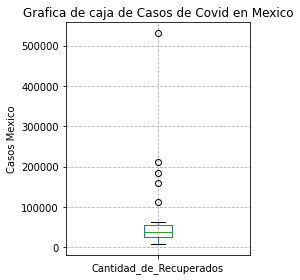

In [ ]:
df_Help_2.loc[:,'Cantidad_de_Recuperados'].plot(kind='box',figsize=(4,4))
plt.title('Grafica de caja de Casos de Covid en Mexico') #Aqui es para agregar el titulo
plt.ylabel('Casos Mexico')
plt.grid(linestyle='--')
plt.tight_layout()

Aqui obtengo la info del segundo df_Help_2 los tipos de datos del df 

In [ ]:
df_Help_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Cantidad_de_Recuperados  32 non-null     int64
 1   Cantidad_de_Fallecidos   32 non-null     int64
 2   Casos                    32 non-null     int64
dtypes: int64(3)
memory usage: 896.0 bytes


Aqui hacemos el plot de las columnas de "Cantidad_de_Recuperados" con  "Casos"

Text(0.5, 1.0, 'Plot de Cant Recuperados')

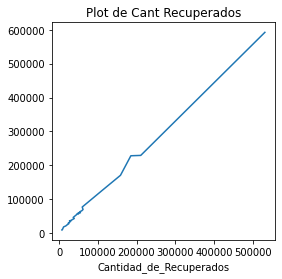

In [ ]:
df_Help_2.plot(x="Cantidad_de_Recuperados", y = 'Casos', legend=False, figsize=(4,4))
plt.title("Plot de Cant Recuperados")  #Aqui es para agregar titulo al grafico 

Aqui hacemos el plot de las columnas de "Cantidad_de_Fallecidos" con "Casos"

Text(0.5, 1.0, 'Plot de Cant fallecidos')

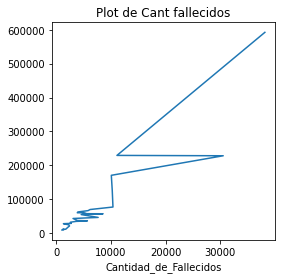

In [ ]:
df_Help_2.plot(x="Cantidad_de_Fallecidos", y='Casos', legend=False, figsize=(4,4))
plt.title("Plot de Cant fallecidos")  #Aqui es para agregar titulo al grafico 

Hacemos dos graficos en una sola ventana 

Text(0.5, 1.0, 'Gráfico de Cant fallecidos')

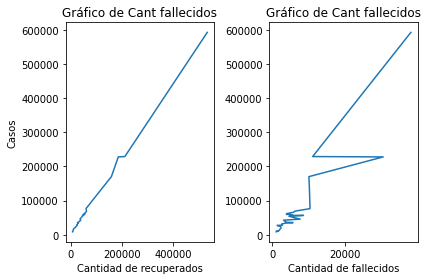

In [ ]:
#Dos gráficos en una sola notación

plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'])
plt.ylabel('Casos')
plt.xlabel('Cantidad de recuperados')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'])
plt.xlabel('Cantidad de fallecidos')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2

Text(0.5, 1.0, 'Gráfico de Cant fallecidos')

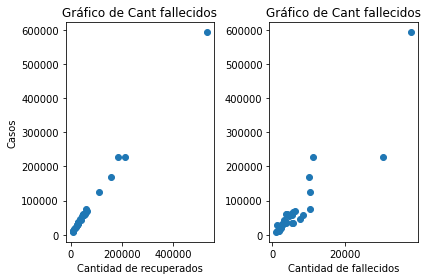

In [ ]:
#DOS GRAFICOS DE PUNTOS en una sola notación

plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'],'o')
plt.ylabel('Casos')
plt.xlabel('Cantidad de recuperados')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'],'o')
plt.xlabel('Cantidad de fallecidos')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2

Text(0.5, 1.0, 'Gráfico de Cant fallecidos')

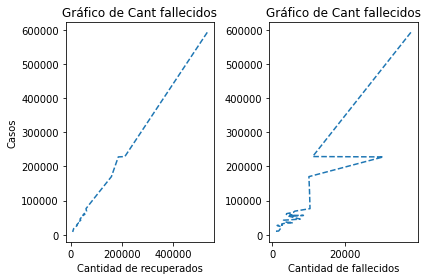

In [ ]:
#DOS GRAFICOS PUNTEADOS en una sola notación.
plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'],'--')
plt.ylabel('Casos')
plt.xlabel('Cantidad de recuperados')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'],'--')
plt.xlabel('Cantidad de fallecidos')
plt.tight_layout()
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2

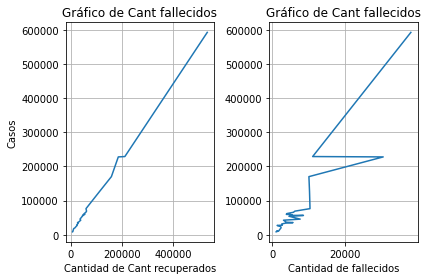

In [ ]:
#DOS GRAFICOS CON LAMINA en una sola notación.
plt.subplot(121) #GRAFICO 1
plt.plot(df_Help_2.loc[:,'Cantidad_de_Recuperados'],df_Help_2.loc[:,'Casos'])
plt.ylabel('Casos')
plt.xlabel('Cantidad de Cant recuperados')
plt.title("Gráfico de Cant fallecidos") #Aqui es para agregar titulo al grafico 1
plt.grid()
plt.tight_layout()
plt.subplot(122) #GRAFICO 2
plt.plot(df_Help_2.loc[:,'Cantidad_de_Fallecidos'],df_Help_2.loc[:,'Casos'])
plt.xlabel('Cantidad de fallecidos')
plt.title("Gráfico de Cant fallecidos")  #Aqui es para agregar titulo al grafico 2
plt.grid()
plt.tight_layout()

Gráfico de casos confirmados con colores 

Text(0.5, 1.0, 'Plot Casos Confirmados COVID en México')

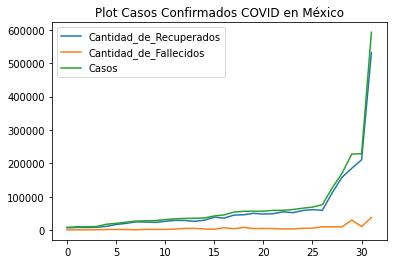

In [ ]:
df_Help_2.sort_values('Casos').reset_index().drop('index',axis = 1).plot(kind = 'line')
plt.title("Plot Casos Confirmados COVID en México")  #Aqui es para agregar titulo al grafico 

Estadistica DESCRIPTIVA

In [ ]:
#Estadistica DESCRIPTIVA de datos
df_Help_2.describe()

,Cantidad_de_Recuperados,Cantidad_de_Fallecidos,Casos
count,32.000000,32.000000,32.000000
mean,65671.406250,6585.843750,75512.156250
std,98227.814059,7879.995379,109367.514837
min,7415.000000,1081.000000,8789.000000
25%,24411.750000,2577.250000,28161.750000
50%,37792.500000,4287.000000,44379.500000
75%,56135.750000,6589.000000,63059.250000
max,531532.000000,38132.000000,592456.000000


In [ ]:
Gráfico de barras de FRECUENCIA 

Text(0.5, 1.0, 'Frecuencias de Casos confirmados COVID en México')

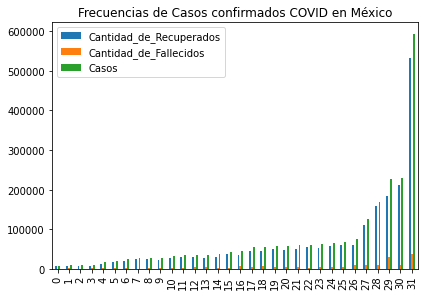

In [ ]:
#Gráfica de barras de FRECUENCIAS de 3 columnas de casos
df_Help_2.sort_values('Casos').reset_index().drop('index',axis = 1).plot(kind = 'bar')
plt.tight_layout()
plt.title("Frecuencias de Casos confirmados COVID en México")  #Aqui es para agregar titulo al grafico 

Text(0.5, 1.0, 'Casos confirmados por Estado')

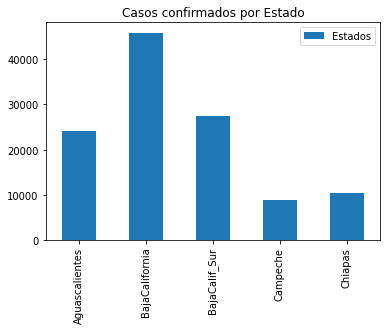

In [ ]:
DJ = pd.DataFrame({'Estados':[24098,45952,27465,8789,10285]},index = ['Aguascalientes','BajaCalifornia','BajaCalif_Sur','Campeche','Chiapas'])
DJ.plot(kind='bar')
plt.title("Casos confirmados por Estado")  #Aqui es para agregar titulo al grafico 


Histograma de casos

In [ ]:
import matplotlib.pyplot as plot

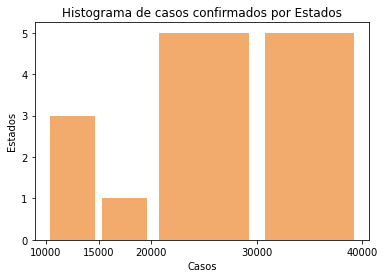

In [ ]:

histograma=df_Help_2["Casos"]
intervalos = [10000,15000,20000,30000,40000] #indicamos los extremos de los intervalos
plot.hist(x=df_Help_2["Casos"], bins=intervalos, color='#F2AB6D', rwidth=0.85,)
plot.title('Histograma de casos confirmados por Estados')
plot.xlabel('Casos')
plot.ylabel('Estados')
plot.xticks(intervalos)

plot.show() #dibujamos el histograma

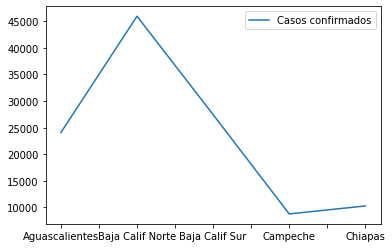

In [ ]:
DJ2 = pd.DataFrame({'Casos confirmados':[24098,45952,27465,8789,10285]},index = ['Aguascalientes','Baja Calif Norte','Baja Calif Sur','Campeche','Chiapas'])
DJ2.plot(kind = 'line')

Aqui sacamos el p valor con Anova

In [ ]:
#Sacamos el p-valor
modl = ols("Cantidad_de_Recuperados ~ Casos", data=df_Help_2).fit()
anova_df = sm.stats.anova_lm(modl, typ=2)
if anova_df["PR(>F)"][0] < 0.005:
    print("hay diferencias")
    print(anova_df)
    # Prueba tukey
    # imprimir los resultados
else:
    print("No hay diferencias")

hay diferencias
                sum_sq    df             F        PR(>F)
Casos     2.985609e+11   1.0  16317.629773  1.303562e-42
Residual  5.489049e+08  30.0           NaN           NaN
